You can find all the data in `../readonly/final_project_data` folder or download it from [Kaggle](https://inclass.kaggle.com/c/competitive-data-science-final-project) if you are solving locally. 

**Good luck!**

In [1]:
# First cell is for: Specify required libraries and their versions in the first
# notebook cell. This will save a lot of time for other students, assessing your project.
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook
from itertools import product
import gc

import warnings
%matplotlib inline
sns.set_context("talk", font_scale=1.4)

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

# Printing versions, my solution has versions:
# numpy 1.13.1
# pandas 0.20.3
# sklearn 0.19.0
# scipy 0.19.1
# lightgbm 2.0.6
# seaborn 0.7.1

for p in [np, pd, sklearn, scipy, lgb, sns]:
    print (p.__name__, p.__version__)

numpy 1.13.1
pandas 0.20.3
sklearn 0.19.0
scipy 0.19.1
lightgbm 2.0.6
seaborn 0.7.1


# Utility functions used throughout. These would be my personal utils file, anything that might be used in the future will go here

In [2]:
# Taken straight from Week 4 lab - Ensembles
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Self explanatory :)
""" Funcion that calculates the root mean squared error"""
def rmse(*args):
    return np.sqrt(mean_squared_error(*args))

# Taken and improved from Week 4 lab - Ensembles
""" This function create the model tablon"""
def get_feature_matrix(sales, test, items):

    # Create "grid" with columns
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    # For every month we create a grid from all shops/items combinations from that month
    grid = []
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

    # Add the 34th entry to test predictions (this is new)
    test['date_block_num'] = 34
    grid = grid.append(test[['shop_id', 'item_id', 'date_block_num']])

    # Groupby data to get shop-item-month aggregates
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    # Fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    # Join it to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # Same as above but with shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # Same as above but with item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    # Downcast dtypes from 64 to 32 bit to save memory
    all_data = downcast_dtypes(all_data)
    del grid, gb 
    gc.collect()

    
    # List of columns that we will use to create lags
    cols_to_rename = list(all_data.columns.difference(index_cols)) 
    lags = [1, 2, 3]
    
    for month_shift in tqdm_notebook(lags):
        train_shift = all_data[index_cols + cols_to_rename].copy()
    
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

    del train_shift

    # Don't use old data from year 2013
    all_data = all_data[all_data['date_block_num'] >= 12]

    # List of all lagged features
    fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in lags]] 
    # We will drop these at fitting stage
    to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

    # Category for each item
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

    all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
    all_data = downcast_dtypes(all_data)
    gc.collect();
    
    return [all_data, to_drop_cols]

def clip20(x):
    return np.clip(x, 0, 20)

def clip40(x):
    return np.clip(x, 0, 20)

# Load Data

In [3]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
test = pd.read_csv('../readonly/final_project_data/test.csv.gz')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_categories = pd.read_csv('../readonly/final_project_data/item_categories.csv')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')

# EDA

*** Let's start by plotting the sum of sales per month, shop, items and item/shop sales. ***

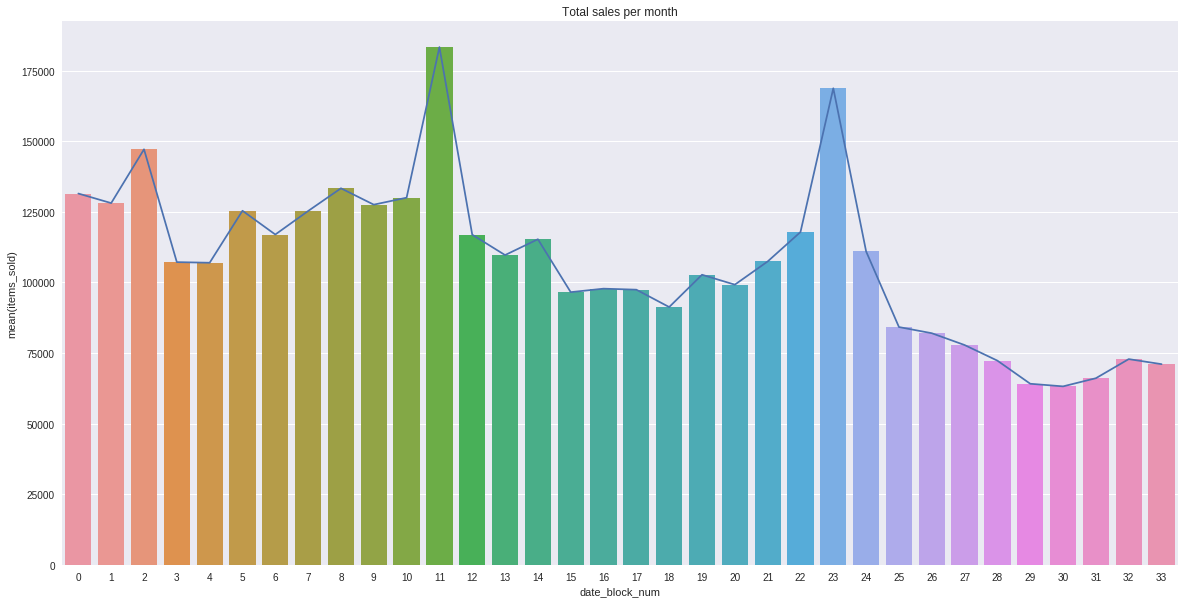

In [4]:
# sales per month (keep in mind if returned it will counterbalance since we're summing item_cnt_day)
sales_per_month = pd.DataFrame(sales.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_per_month.columns = ['date_block_num', 'items_sold']
sns.barplot(x = sales_per_month.columns[0], y = sales_per_month.columns[1], data = sales_per_month.reset_index())
plt.plot(sales_per_month.items_sold)
plt.title('Total sales per month')
# RAM is precious :)
del sales_per_month
# Noticing some high sales on 11 and 23 (november/december prod due to christmas)

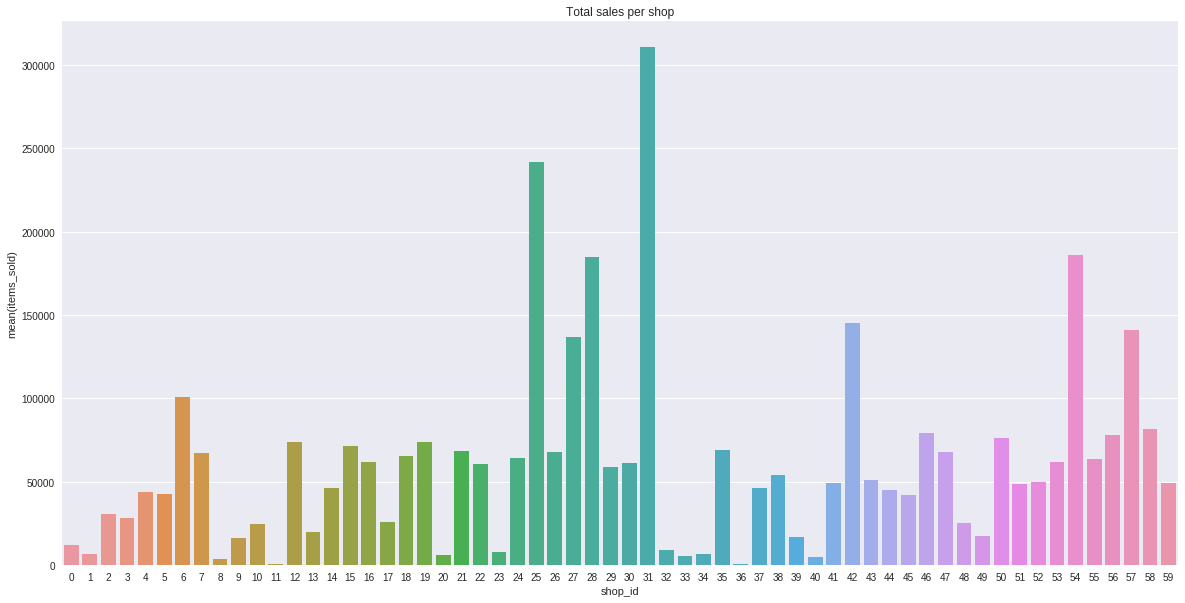

In [5]:
# sales per shop
sales_per_shop = pd.DataFrame(sales.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_per_shop.columns = ['shop_id', 'items_sold']
sns.barplot(x = sales_per_shop.columns[0], y = sales_per_shop.columns[1], data = sales_per_shop.reset_index())
plt.title('Total sales per shop')
# RAM is precious :)
del sales_per_shop
# Some high numbers on a few shops and few numbers on others but nothing out of this world. Poor shop 36

In [10]:
# sales per item
sales_per_item = pd.DataFrame(sales.groupby(['item_id']).sum().item_cnt_day).reset_index()
sales_per_item.columns = ['item_id', 'items_sold']
# For some reason this takes a large ammount of time... So plotting is commented in. Just ran some max/min/std/mean observations
# sns.barplot(x = sales_per_item.columns[0], y = sales_per_item.columns[1], data = sales_per_item.reset_index())
# plt.plot(sales_per_item.items_sold)
# plt.title('Total sales per item')
print("Min: ", sales_per_item['items_sold'].min())
print("Max: ", sales_per_item['items_sold'].max())
print("Mean: ", sales_per_item['items_sold'].mean())
print("Stddev: ", sales_per_item['items_sold'].std())

# RAM is precious :)
# del sales_per_item
# Goddamn there's a clear anomaly here. Mean is 167 and stddev is 1366 but there's a 187642... :)

Min:  -11.0
Max:  187642.0
Mean:  167.295180447
Stddev:  1366.22019007


In [11]:
# Getting the super_sell_item and making sure it's one of a kind (checking if unique and next in line since no graph)
max_sold = sales_per_item['items_sold'].max()
super_sell_item = sales_per_item[sales_per_item['items_sold'] == max_sold]['item_id'].iloc[0]
print('anomaly: ', super_sell_item)
print('anomaly value: ', sales_per_item[sales_per_item['item_id'] == super_sell_item]['items_sold'].iloc[0])
print('same sales number: ', sales_per_item[sales_per_item['items_sold'] == max_sold].shape[0])
print('next in line value: ', sales_per_item[sales_per_item['items_sold'] != 187642.0]['items_sold'].max())
# RAM is precious :)
del sales_per_item
# Since the next in line is 17245 it seems much more in line with results (altough a bit high). No other with same sales.

anomaly:  20949
anomaly value:  187642.0
same sales number:  1
next in line value:  17245.0


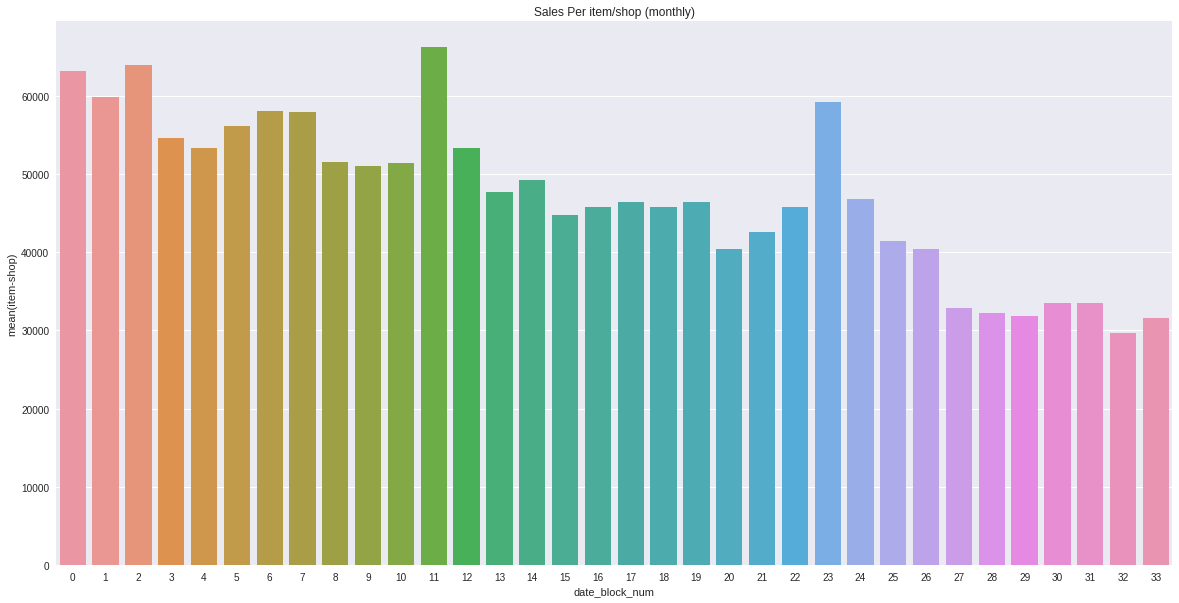

In [12]:
# sales per item/shop
sales_per_item_shop = pd.DataFrame(sales[['date_block_num', 'item_id', 'shop_id']].drop_duplicates().groupby('date_block_num').size()).reset_index()
sales_per_item_shop.columns = ['date_block_num', 'item-shop']
sns.barplot(x = sales_per_item_shop.columns[0],
            y = sales_per_item_shop.columns[1],
            data = sales_per_item_shop.reset_index())
#plt.plot(sales_per_item_shop['item-shop']);
plt.title('Sales Per item/shop (monthly)')
del sales_per_item_shop
# quite standard

*** Let's bring data from other things and plot item_categories sales. ***

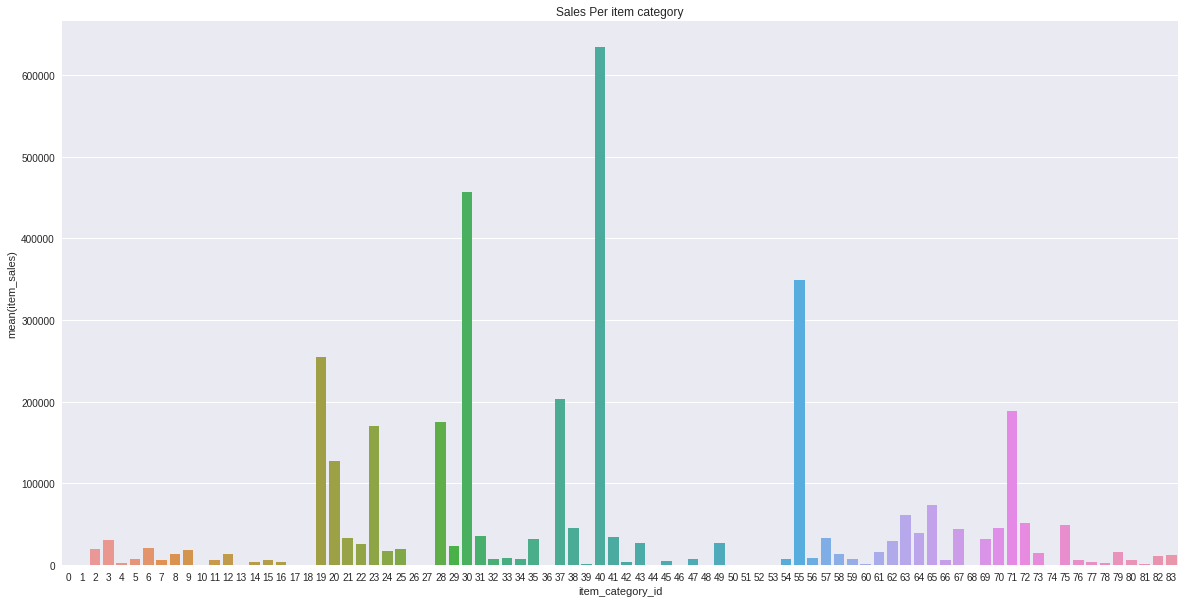

In [13]:
sales_per_item_category = pd.DataFrame(sales.merge(items, how = 'left', on = 'item_id').groupby('item_category_id').item_cnt_day.sum()).reset_index()
sales_per_item_category.columns = ['item_category_id', 'item_sales']
sns.barplot(x = sales_per_item_category.columns[0],
            y = sales_per_item_category.columns[1],
            data = sales_per_item_category.reset_index())
plt.title('Sales Per item category')
del sales_per_item_category
# A few categories are clearly favored.

In [14]:
# Top 10 categories
sales_per_item_category = pd.DataFrame(sales.merge(items, how = 'left', on = 'item_id').groupby('item_category_id').item_cnt_day.sum()).reset_index()
sales_per_item_category.columns = ['item_category_id', 'item_sales']
sales_per_item_category.sort_values(by=['item_sales'], ascending = False, inplace = True)
category_names = pd.DataFrame(sales_per_item_category.head(10).merge(item_categories, how = 'left', on = 'item_category_id')).reset_index()
print('TOP 10 sales: ', sales_per_item_category.head(10)['item_sales'])
print('TOP 10 categories: ', category_names.head(10)['item_category_name'])
del sales_per_item_category
del category_names
# Goddamn nerds. PS3, CD, DVD, PC, PS4 etc... Sales drop quite quickly 456540.0 at 1st vs 73077.0 in 10th

TOP 10 sales:  40    634171.0
30    456540.0
55    348591.0
19    254887.0
37    203284.0
71    187998.0
28    174954.0
23    169944.0
20    127319.0
65     73077.0
Name: item_sales, dtype: float64
TOP 10 categories:  0                                  Кино - DVD
1               Игры PC - Стандартные издания
2         Музыка - CD локального производства
3                                  Игры - PS3
4                              Кино - Blu-Ray
5    Подарки - Сумки, Альбомы, Коврики д/мыши
6            Игры PC - Дополнительные издания
7                             Игры - XBOX 360
8                                  Игры - PS4
9      Подарки - Настольные игры (компактные)
Name: item_category_name, dtype: object


# Data Leakage

*** I have a bit of an issue with data leakage since my goal with this course was more to get to know more advanced concepts, not really win Kaggle competitions. I feel data leakage is good for a competition but it's kind of a cheat approach. Nevertheless, this is part of the course so exploring a bit. Let's check wich combinations of items/shops do exist in the test data and try to model using that knowledge ***

In [15]:
tuples_train = pd.Series(list(sales[['item_id', 'shop_id']].itertuples(index = False, name = None)))
tuples_test = pd.Series(list(test[['item_id', 'shop_id']].itertuples(index = False, name = None)))
common = tuples_train.isin(tuples_test).sum()
print('percentage in test: ', str((common / len(tuples_train)) * 100))
del tuples_train
del tuples_test
del common
# Only around 42% is on the test set. This is nice since we can't make things better

percentage in test:  41.7064705985


*** We can save the ids that appear in the test set on each month. By having this data, our model can infer the predictions on items not present on the test month better (where the data is not present).
We also create the input for the submission with the date_block_num = 34 (training ends at 33) and ignore old data (similar to week 4 lab) ***

*** To aid in this, we rely and improve the week 4 course method (present above on the utils) ***

In [16]:
sales_for_items_in_test = sales[sales.item_id.isin(test.item_id)]

[all_data, to_drop_cols] = get_feature_matrix(sales_for_items_in_test, test, items)

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


A Jupyter Widget

In [17]:
# Just checking stuff here
print('to_drop_cols: ', to_drop_cols)
print('data: ', all_data.head(10))

to_drop_cols:  ['target', 'target_item', 'target_shop', 'date_block_num']
data:     shop_id  item_id  date_block_num  target  target_shop  target_item  \
0       54    10297              12     4.0       3416.0         23.0   
1       54    10298              12    14.0       3416.0        182.0   
2       54    10300              12     3.0       3416.0         26.0   
3       54    10292              12     9.0       3416.0         93.0   
4       54    10143              12     1.0       3416.0         12.0   
5       54    10148              12     1.0       3416.0         14.0   
6       54    10287              12     1.0       3416.0          4.0   
7       54    10164              12     1.0       3416.0          5.0   
8       54    10325              12     3.0       3416.0         23.0   
9       54    10331              12     4.0       3416.0         30.0   

   target_lag_1  target_item_lag_1  target_shop_lag_1  target_lag_2  \
0           3.0               42.0          

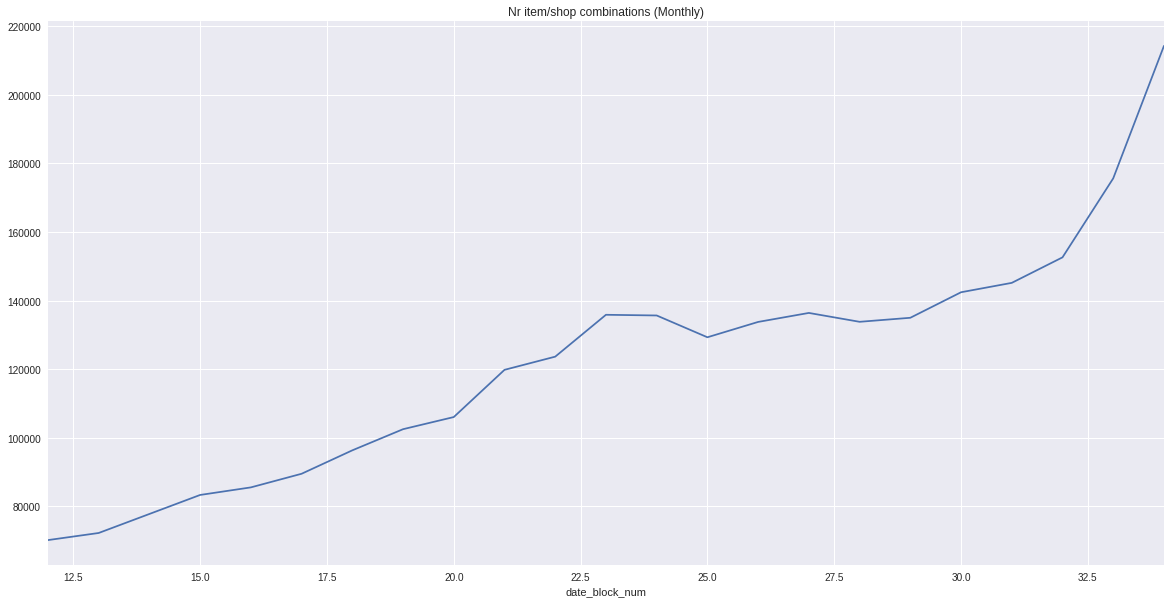

In [18]:
# Let's just plot bit more data here, group by month should give item/shop combinations monthly
plt.title('Nr item/shop combinations (Monthly)')
all_data.groupby('date_block_num').size().plot();
# quite a rise at then end but I think it's more due to being low a bit before. Nothing really relevant.

# Mean encodings

*** Let's do some mean encodings by the categories of the items. It's clear they're very related to sales. ***

In [19]:
mean_encoding = pd.DataFrame(all_data.groupby(['shop_id', 'item_category_id']).target.agg(['mean', 'var']).reset_index())
mean_encoding.columns = ['shop_id', 'item_category_id', 'mean_encoding', 'variance_encoding']
all_data = pd.merge(all_data, mean_encoding, how = 'left', on = ['shop_id', 'item_category_id'])
del mean_encoding
all_data = downcast_dtypes(all_data)

# Train/Dev/Test split

*** Take the 34th month from the data to be the submission. Test ***

In [27]:
backup_data = all_data.copy()
X_test = backup_data[backup_data['date_block_num'] == 34].fillna(0)
backup_data = backup_data[backup_data['date_block_num'] < 34].fillna(0)
X_test.head()

shop_id  item_id  date_block_num  target  target_shop  target_item  \
2582558        5     5037              34     0.0          0.0          0.0   
2582559        5     5320              34     0.0          0.0          0.0   
2582560        5     5233              34     0.0          0.0          0.0   
2582561        5     5232              34     0.0          0.0          0.0   
2582562        5     5268              34     0.0          0.0          0.0   

         target_lag_1  target_item_lag_1  target_shop_lag_1  target_lag_2  \
2582558           0.0               25.0             1032.0           1.0   
2582559           0.0                0.0                0.0           0.0   
2582560           1.0               42.0             1032.0           3.0   
2582561           0.0               28.0             1032.0           0.0   
2582562           0.0                0.0                0.0           0.0   

         target_item_lag_2  target_shop_lag_2  target_lag_3  \
2582558              110.0             1041.0           3.0   
2582559                0.0                0.0           0.0   
2582560               80.0             1041.0           1.0   
2582561               48.0             1041.0           1.0   
2582562                0.0                0.0           0.0   

         target_item_lag_3  target_shop_lag_3  item_category_id  \
2582558              119.0             1218.0                19   
2582559                0.0                0.0                55   
2582560              150.0             1218.0                19   
2582561               65.0             1218.0                23   
2582562                0.0                0.0                20   

         mean_encoding  variance_encoding  
2582558       0.732243           2.520294  
2582559       0.231153           0.419340  
2582560       0.732243           2.520294  
2582561       0.525198           1.185722  
2582562       1.133001          12.286789

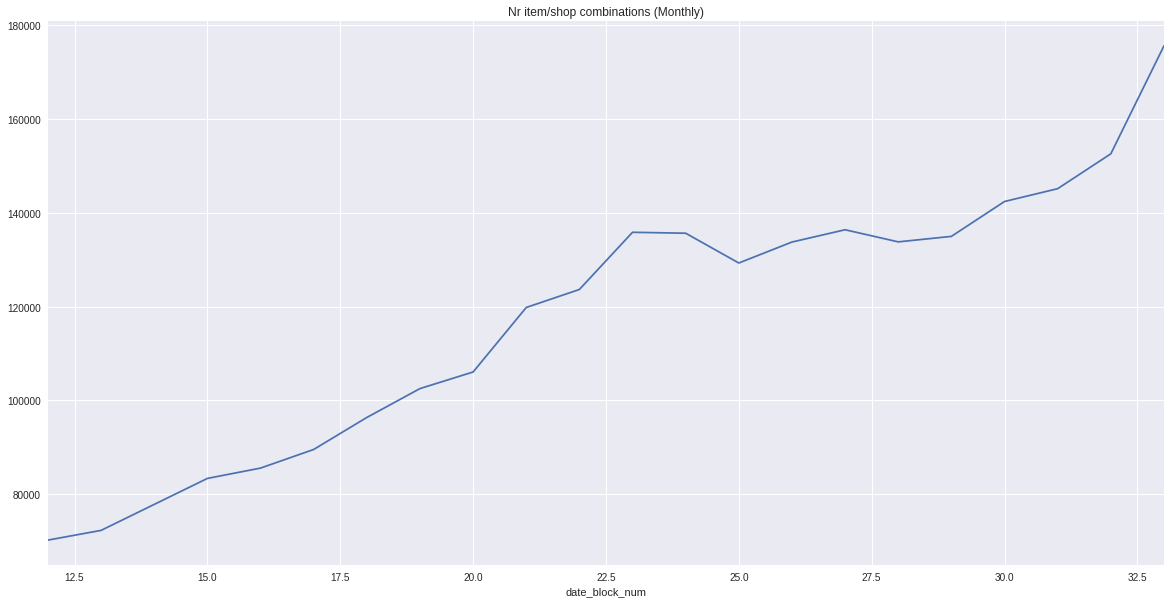

In [28]:
# Simple replot to check if things went alright
plt.title('Nr item/shop combinations (Monthly)')
backup_data.groupby('date_block_num').size().plot();
# Everything good :)

*** Let's separate validation and train from current data. ***

In [29]:
# Get months 22/31/32/33 to be the validations. In the future, close to the predictions we want :)
validation_booleans = backup_data['date_block_num'].isin([22, 31, 32, 33])
train_booleans = backup_data['date_block_num'].isin([22, 31, 32, 33]) == False

# Remember to drop the columns :)
X_train = backup_data.loc[train_booleans].drop(to_drop_cols, axis = 1)
X_validation =  backup_data.loc[validation_booleans].drop(to_drop_cols, axis = 1)
X_test = X_test.drop(to_drop_cols, axis = 1)
Y_train = backup_data.loc[train_booleans]['target'].values
Y_validation =  backup_data.loc[validation_booleans]['target'].values

In [30]:
print('v: ', validation_booleans.head(5))
print('t: ', train_booleans.head(5))

print('X_train: ', X_train.head(5))
print('X_validation: ', X_validation.head(5))
print('X_test: ', X_test.head(5))
print('Y_train: ', Y_train[:4])
print('Y_validation: ', Y_validation[:4])

v:  0    False
1    False
2    False
3    False
4    False
Name: date_block_num, dtype: bool
t:  0    True
1    True
2    True
3    True
4    True
Name: date_block_num, dtype: bool
X_train:     shop_id  item_id  target_lag_1  target_item_lag_1  target_shop_lag_1  \
0       54    10297           3.0               42.0             4282.0   
1       54    10298          21.0              369.0             4282.0   
2       54    10300           1.0               54.0             4282.0   
3       54    10292           8.0              156.0             4282.0   
4       54    10143           1.0               18.0             4282.0   

   target_lag_2  target_item_lag_2  target_shop_lag_2  target_lag_3  \
0           0.0                2.0             3085.0           0.0   
1         119.0             1309.0             3085.0           7.0   
2          31.0              361.0             3085.0           0.0   
3          16.0              203.0             3085.0          15.0   
4  

In [32]:
# This is a great place to save. Data has been treated and separated into the components:
X_train.to_csv('data/X_train.csv', index = False)
X_validation.to_csv('data/X_validation.csv', index = False)
X_test.to_csv('data/X_test.csv', index = False)
np.save(arr=Y_train, file='data/Y_train.npy')
np.save(arr=Y_validation, file='data/Y_validation.npy')


# Haven't had to recover the data from the disk but just in case this can help????
X_train = pd.read_csv('data/X_train.csv')
X_validation = pd.read_csv('data/X_validation.csv')
X_test = pd.read_csv('data/X_test.csv')
Y_train = np.load('data/Y_train.npy')
Y_validation = np.load('data/Y_validation.npy')

In [33]:
# print things again to make sure everything is fine
print('X_train: ', X_train.head(5))
print('X_validation: ', X_validation.head(5))
print('X_test: ', X_test.head(5))
print('Y_train: ', Y_train[:4])
print('Y_validation: ', Y_validation[:4])

X_train:     shop_id  item_id  target_lag_1  target_item_lag_1  target_shop_lag_1  \
0       54    10297           3.0               42.0             4282.0   
1       54    10298          21.0              369.0             4282.0   
2       54    10300           1.0               54.0             4282.0   
3       54    10292           8.0              156.0             4282.0   
4       54    10143           1.0               18.0             4282.0   

   target_lag_2  target_item_lag_2  target_shop_lag_2  target_lag_3  \
0           0.0                2.0             3085.0           0.0   
1         119.0             1309.0             3085.0           7.0   
2          31.0              361.0             3085.0           0.0   
3          16.0              203.0             3085.0          15.0   
4           0.0                2.0             3085.0           0.0   

   target_item_lag_3  target_shop_lag_3  item_category_id  mean_encoding  \
0                0.0                

In [34]:
# Let's get a feel of our dataset size :)
print('X_train shape: ', X_train.shape)
print('X_validation shape:', X_validation.shape)
print('% Validation of full data:',  (((X_validation.shape[0] / (X_validation.shape[0] + X_train.shape[0])) * 100)))
# Validation is 23% of the full data rows. Considering the number of rows we have this seems fine

X_train shape:  (1985566, 14)
X_validation shape: (596992, 14)
% Validation of full data: 23.116305616369505


In [35]:
# Let's make sure our data leak worked, let's see the amount of item-shopids that are present on the validation set:
# FROM THE DATA LEAK:
# tuples_train = pd.Series(list(sales[['item_id', 'shop_id']].itertuples(index = False, name = None)))
tuples_validation = pd.Series(list(X_validation[['item_id', 'shop_id']].itertuples(index = False, name = None)))
tuples_test = pd.Series(list(test[['item_id', 'shop_id']].itertuples(index = False, name = None)))
common = tuples_validation.isin(tuples_test).sum()
print('percentage in test from the validation: ', str((common / len(tuples_validation)) * 100))
del tuples_test
del tuples_validation
del common

percentage in test from the validation:  93.7473198971


# Models

*** Let's create two models. First will be LightGBM similar to week 4 on ensembles. Then let's create a random forest. Both will be used later in stacking ***

In [49]:
# Let's test a few configs with the learning rate and see how it goes. I've tested before with leaf and depth
# values but they seem to not really change anything (seen from docs game me the idea).
# From their docs
# To get good results using a leaf-wise tree, these are some important parameters:
# num_leaves. This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.
# min_data_in_leaf. This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
# max_depth. You also can use max_depth to limit the tree depth explicitly.

# Previous attempt
"""        
lgb_params_1 = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**3, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**5,
               'bagging_freq':1,
               'verbose':0,
               'max_depth':6,
              }
lgb_params_2 = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**5, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               'max_depth':8,
              }
lgb_params_3 = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**5, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               'max_depth':-1, #as default unbounded
              }
# this should give us enough for a rough estimation. Hopefully I would spend more time really improving these
# params but I'm running everything on coursera and again, it's not really what I'm after, just showcasing.
lgb_iterations = 100

lgb_model_1 = lgb.train(lgb_params_1, lgb.Dataset(X_train, label = Y_train), lgb_iterations)
lgb_model_2 = lgb.train(lgb_params_2, lgb.Dataset(X_train, label = Y_train), lgb_iterations)
lgb_model_3 = lgb.train(lgb_params_3, lgb.Dataset(X_train, label = Y_train), lgb_iterations)

# store/load everything
pickle.dump(lgb_model_1, open('models/lgm_1.pickle', "wb"))
pickle.dump(lgb_model_2, open('models/lgm_2.pickle', "wb"))
pickle.dump(lgb_model_3, open('models/lgm_3.pickle', "wb"))
#lgb_model_1 = pickle.load(open('models/lgm_1.pickle', "rb"))
#lgb_model_2 = pickle.load(open('models/lgm_2.pickle', "rb"))
#lgb_model_3 = pickle.load(open('models/lgm_3.pickle', "rb"))

# LGB Models stats
train_pred_lgb_1 = lgb_model_1.predict(X_train)
train_pred_lgb_2 = lgb_model_2.predict(X_train)
train_pred_lgb_3 = lgb_model_3.predict(X_train)
validation_pred_lgb_1 = lgb_model_1.predict(X_validation)
validation_pred_lgb_2 = lgb_model_2.predict(X_validation)
validation_pred_lgb_3 = lgb_model_3.predict(X_validation)
print('LGB Model 1 Train RMSE: ', rmse(clip20(Y_train), clip20(train_pred_lgb_1)))
print('LGB Model 1 Validation RMSE: ', rmse(clip20(Y_validation), clip20(validation_pred_lgb_1)))
print('LGB Model 2 Train RMSE: ', rmse(clip20(Y_train), clip20(train_pred_lgb_2)))
print('LGB Model 2 Validation RMSE: ', rmse(clip20(Y_validation), clip20(validation_pred_lgb_2)))
print('LGB Model 3 Train RMSE: ', rmse(clip20(Y_train), clip20(train_pred_lgb_2)))
print('LGB Model 3 Validation RMSE: ', rmse(clip20(Y_validation), clip20(validation_pred_lgb_2)))

OUTPUT:
LGB Model 1 Train RMSE:  1.14548841938
LGB Model 1 Validation RMSE:  1.13079314913
LGB Model 2 Train RMSE:  1.12357495175
LGB Model 2 Validation RMSE:  1.13621355189
LGB Model 3 Train RMSE:  1.12357495175
LGB Model 3 Validation RMSE:  1.13621355189
"""

learning_rates = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1]
best_lgb_rmse = 9999999 # This should be enought :)
for learning_rate in learning_rates:
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread': 4, 
               'min_data_in_leaf': 2**5, 
               'bagging_fraction': 0.75, 
               'learning_rate': learning_rate, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq': 1,
               'verbose':0 
              }

    # From docs: As a general rule, if you reduce num_iterations, you should increase learning_rate.
    # This seems somewhat sensible but we could also had this to the hyperparameters search
    iterations = int(100 * (0.05 / learning_rate))
    print('learning rate: ', learning_rate)
    print('iterations: ', iterations)

    lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label = clip40(Y_train)), iterations)
    validation_pred_lgb = lgb_model.predict(X_validation)
    rmse_score = rmse(clip20(Y_validation), clip20(validation_pred_lgb))
    print('rmse: ', rmse_score)

    if rmse_score < best_lgb_rmse:
        best_lgb_rmse = rmse_score
        best_lgb_learning_rate = learning_rate
        
print('best_lgb_learning_rate: ', best_lgb_learning_rate)

learning rate:  0.01
iterations:  500
rmse:  1.04422814297
learning rate:  0.03
iterations:  166
rmse:  1.04497909268
learning rate:  0.05
iterations:  100
rmse:  1.04986176463
learning rate:  0.07
iterations:  71
rmse:  1.05172664097
learning rate:  0.09
iterations:  55
rmse:  1.04849251912
learning rate:  0.1
iterations:  50
rmse:  1.04920276684
best_lgb_learning_rate:  0.01


In [51]:
# Train with full data
X = X_train.append(X_validation)
Y = np.append(Y_train, Y_validation)
best_lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread': 4, 
               'min_data_in_leaf': 2**5, 
               'bagging_fraction': 0.75, 
               'learning_rate': best_lgb_learning_rate, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }
iterations = int(100 * (0.05 / best_lgb_learning_rate)) 

best_lgb_model = lgb.train(lgb_params, lgb.Dataset(X, label = clip40(Y)), iterations)

# Store best
pickle.dump(best_lgb_model, open('models/lgm_best.pickle', "wb"))

In [54]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV

# Random Forest model.
X = X_train.append(X_validation)
Y = np.concatenate([Y_train, Y_validation])
# I don't remember how to initialize with a value and this might be quicker?
train_indices = np.zeros(X.shape[0])
for i in range(0, len(X_train)):
    train_indices[i] = -1

split = PredefinedSplit(test_fold = (train_indices))

# Grid search for hyperparameters search
# param_grid = {'max_features': [4, 8]}
param_grid = {'max_features': [4, 8], 'max_depth': [None, 4, 12], 'bootstrap': [0.7, 0.8]}
n_trees = 10
grid_search = GridSearchCV(cv = split,
                  estimator = RandomForestRegressor(n_estimators = n_trees, n_jobs = 4), 
                  param_grid = param_grid,
                  scoring = 'neg_mean_squared_error')

grid_search.fit(X, clip40(Y))
best_rf_model = grid_search.best_estimator_
print('best_rf_model: ', best_rf_model)

best_rf_model:  RandomForestRegressor(bootstrap=0.7, criterion='mse', max_depth=12,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [55]:
# Train with full data
X = X_train.append(X_validation)
Y = np.append(Y_train, Y_validation)

best_rf_model.fit(X, clip40(Y))

# Store best
pickle.dump(best_rf_model, open('models/rf_best.pickle', "wb"))

# Ensemble/Stacking

In [56]:
# Start from here if you don't want to train any model. Everything should be present including data:
lgb_model = pickle.load(open('models/lgm_best.pickle', "rb"))
rf_model = pickle.load(open('models/rf_best.pickle', "rb"))

# Haven't had to recover the data from the disk but just in case this can help????
X_train = pd.read_csv('data/X_train.csv')
X_validation = pd.read_csv('data/X_validation.csv')
X_test = pd.read_csv('data/X_test.csv')
Y_train = np.load('data/Y_train.npy')
Y_validation = np.load('data/Y_validation.npy')

LGB Best Model Train RMSE:  0.869915234761
LGB Best Model Validation RMSE:  0.837266112716


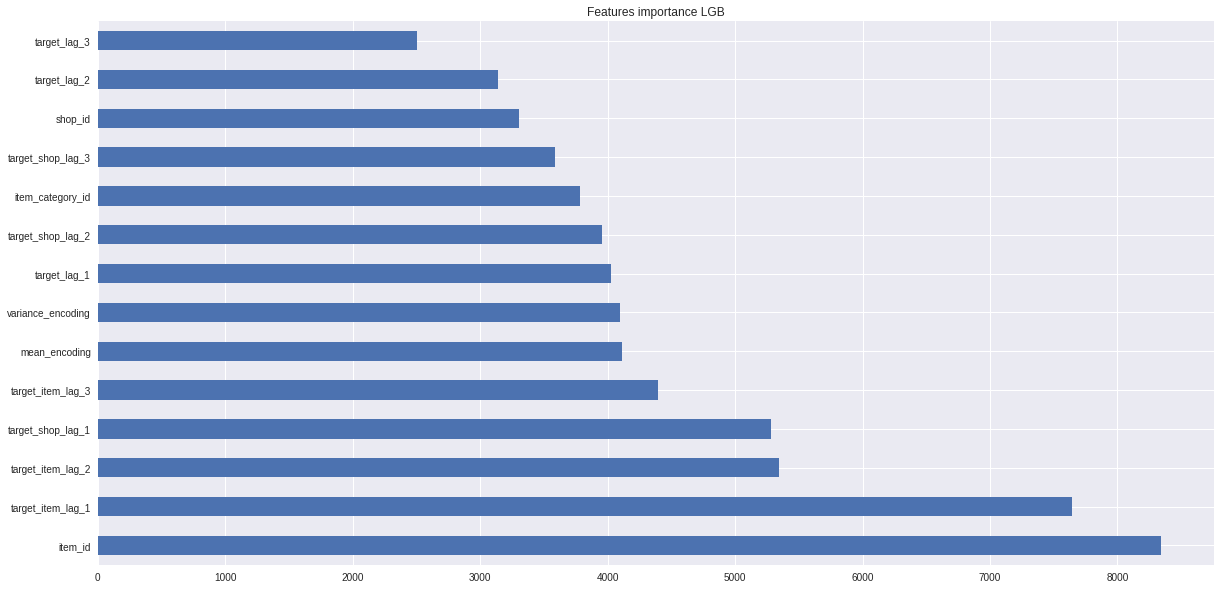

In [57]:
# LGB Model stats
train_pred_lgb = lgb_model.predict(X_train)
validation_pred_lgb = lgb_model.predict(X_validation)
print('LGB Best Model Train RMSE: ', rmse(clip20(Y_train), clip20(train_pred_lgb)))
print('LGB Best Model Validation RMSE: ', rmse(clip20(Y_validation), clip20(validation_pred_lgb)))

feature_imp = pd.Series(lgb_model.feature_importance(), index = X_validation.columns)
feature_imp = feature_imp.nlargest(15)
feature_imp.plot(kind='barh')
plt.title('Features importance LGB')
plt.show()
# We can see the lags had their effect since they are important features :)

RF Best Model Train RMSE: 1.02711078927
RF Best Model Validation RMSE: 0.981804475762


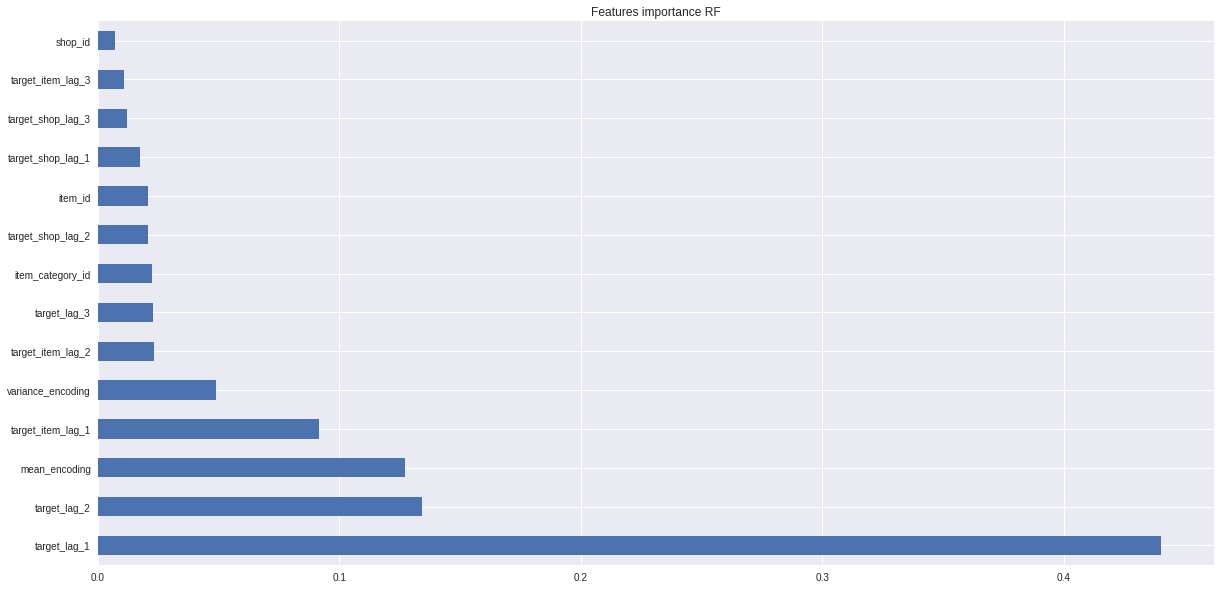

In [58]:
# RF Model stats
train_pred_rf = rf_model.predict(X_train)
validation_pred_rf = rf_model.predict(X_validation)
print('RF Best Model Train RMSE:', rmse(clip20(Y_train), clip20(train_pred_rf)))
print('RF Best Model Validation RMSE:', rmse(clip20(Y_validation), clip20(validation_pred_rf)))

feature_imp = pd.Series(rf_model.feature_importances_, index = X_validation.columns)
feature_imp = feature_imp.nlargest(15)
feature_imp.plot(kind='barh')
plt.title('Features importance RF')
plt.show()

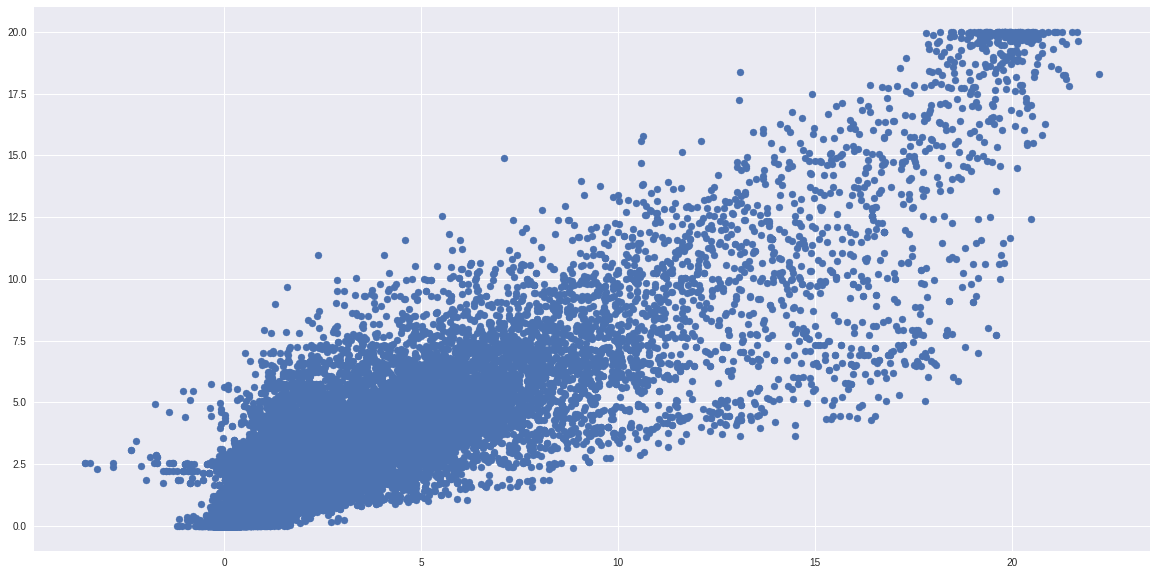

In [59]:
# Correlations
plt.scatter(validation_pred_lgb, validation_pred_rf)

In [60]:
# Level 2 - Teachers
# Just gonna make this a linear regression. We do want it simple :)

# forgot to import this but should be fine importing here. I do got the library
from sklearn.metrics import r2_score

# concatenating predictions from both models
concatenated = np.c_[validation_pred_lgb, validation_pred_rf]
print('concatenated: ', concatenated)

meta_model = LinearRegression()
meta_model.fit(concatenated, clip40(Y_validation))
pred_meta_model_validation = clip20(meta_model.predict(concatenated))

print('Test R-squared for linreg is %f' % r2_score(Y_validation, pred_meta_model_validation))
print('Test RMSE for linreg is %f' % rmse(clip20(Y_validation), clip20(pred_meta_model_validation)))

concatenated:  [[ 9.78366245  5.72591209]
 [ 0.30868383  0.34753022]
 [ 1.86068899  1.50891181]
 ..., 
 [ 0.08548878  0.07624239]
 [ 0.3029175   0.24078972]
 [ 0.07335242  0.04639063]]
Test R-squared for linreg is 0.146981
Test RMSE for linreg is 0.824751


# Submission

In [ ]:
# Let's generate the final predictions and submit. See how this goes for now :)

lgb_test = lgb_model.predict(X_test.fillna(0))
rf_test = rf_model.predict(X_test.fillna(0))
concatenated = np.c_[lgb_test, rf_test]

final_predictions = clip20(meta_model.predict(concatenated))

predictions = pd.DataFrame()
predictions['shop_id'] = test.shop_id
predictions['item_id'] = test.item_id
predictions['item_cnt_month'] = final_predictions
submission = test[['ID', 'shop_id', 'item_id']].merge(predictions, on = ['shop_id', 'item_id'], how = 'left').fillna(0)
submission[['ID', 'item_cnt_month']].to_csv('submission.csv', index = False)

In [47]:
# Since the models keep expiring while searching for hyperparameters, this will help me export and run things locally
# https://www.zerotosingularity.com/blog/coursera-jupyter-locally/
# !tar chvzf notebook.tar.gz --exclude notebook.tar.gz *

# final submission is in zip so put everything there
!zip -r submission.zip ./

data/
data/Y_validation.npy
data/X_validation.csv
data/X_test.csv
data/Y_train.npy
data/X_train.csv
main.ipynb
models/
models/lgm_3.pickle
models/lgm_1.pickle
models/lgm_best.pickle
models/rf_best.pickle
models/lgm_2.pickle
submission.csv
